In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import sodshock

### Not so fast!

Use a perturbation analysis to show that the leapfrog scheme (time-centered
difference):
$$
\rho^{n+1}_j - \rho^{n-1}_j = -v_0 \frac{\Delta t}{\Delta x}(\rho^{n}_{j+1} - \rho^{n}_{j-1} )
$$
is conditionally stable, i.e. it is stable as long as $\Delta t \leq \Delta x/v_0$. Assume that $v_0$ is a constant velocity.

Perturbation:
$$
\rho_j^n(k) = \xi_j^n e^{ikj\Delta x}
$$

Subbing into equation above:
$$
\xi_j^{n+1} e^{ikj\Delta x} - \xi_j^{n-1} e^{ikj\Delta x} = -v_0 \frac{\Delta t}{\Delta x}(\xi_{j}^{n} e^{ik(j+1)\Delta x} -\xi_{j}^{n} e^{ik(j-1)\Delta x})
$$
We can then simplify this to
$$
\xi_j^{n+1} - \xi_j^{n-1}  = -v_0 \frac{\Delta t}{\Delta x}(\xi_{j}^{n} e^{ik\Delta x} -\xi_{j}^{n} e^{-ik\Delta x}) \\
\xi - \xi^{-1} = -v_0 \frac{\Delta t}{\Delta x}( e^{ik\Delta x|}- e^{-ik\Delta x}) \\
\xi - \xi^{-1} = -2i v_0 \frac{\Delta t}{\Delta x} sin(k \Delta x)
$$
squaring both sides, we get:
$$
\xi^2 -2/\xi +1/\xi^2 = 4\Big(v_0 \frac{\Delta t}{\Delta x} \Big)^2 sin^2(k \Delta x)
$$
for $\Delta t \leq \Delta x/v_0$ or $v_0 \frac{\Delta t}{\Delta x} \leq 1$, we can see that $\xi$, or the perturbation will remain <1, therefore be stable. However, if $\Delta t > \Delta x/v_0$, it is easy to see that the perturbation will grow over time, thus be unstable, showing that the leapfrog scheme is conditionally stable given $\Delta t \leq \Delta x/v_0$.

### Sod it!

Using the finite volume discretization given in class and a programming language
of your choice, write your own 1D hydrodynamic solver.

a) The quintessential shock benchmark problem is the “Sod Shock Tube” (first formulated
by Sod in 1978). The problem involves setting up two discontinuous states at $t = 0$: a hot
dense gas on the left and a cool, low-density gas on the right. The result is a shock wave
that travels left to right into the cold gas, and a rarefaction wave that travels into the dense
gas on the left.

$\it{Setup}$: Let the domain be [0,2], and set $\rho_1$ = 1.0, $p_1$ = 1.0 for $x \leq$0.75 and $\rho_2$ = 0.125, $p_2$ = 0.1 for $ x >$ 0.75. Assume $\gamma$ = 1.4 and use this to determine the specific energy. Set
$v$ = 0 everywhere initially. Use symmetry boundary conditions and $N$ = 200 grid cells. Set
the time step according to a CFL number of 0.5. implement an artificial viscosity of the
form:

$$
\begin{align}
q_{i+1/2}^{n} &= [q_0 (u^n_{i+1}-u_i^n)^2 - q_1 (u^n_{i+1}-u_i^n)] \frac{c_{s,i+1/2}}{\bar{\rho}} & \Big( \frac{u^n_{i+1}-u_i^n}{x^n_{i+1}-x_i^n} \Big) < 0 \\
q_{i+1/2}^{n} &= 0 & \Big( \frac{u^n_{i+1}-u_i^n}{x^n_{i+1}-x_i^n} \Big) > 0
\end{align}
$$

where $\bar{\rho} = \Big( \frac{1}{\rho^{n+1}_{i+1/2}} +  \frac{1}{\rho^{n}_{i+1/2}} \Big)$, $q_0$ = 4 and $q_1$ = 0.5.

Compute the solution at $t$ = 0.245 and make plots of the density, velocity, pressure and
specific energy as a function of position. Compare the shock properties (speed, density
jump, pressure jump, velocity) with that predicted for these conditions (e.g. see Stone &
Norman 1992).

In [65]:
class Fluid:
    """
    Container that houses all fluid components
    """
    def __init__(self, gamma = 1.4, CFL = 0.5, N=200, xmin = 0., xmax = 2.):
        ### Just to store my constants
        self.CFL = CFL
        self.gamma = gamma
        self.N = N
        self.xmin = xmin
        self.xmax = xmax

        # Each array has N cells + 2 ghost cells, the components measured on the edge have an extra cell (N+3)
        self.v = np.zeros(self.N+3, dtype=np.float64)
        self.rho = np.zeros(self.N+2, dtype=np.float64)
        self.cs = np.zeros(self.N+2, dtype=np.float64)
        self.e = np.zeros(self.N+2, dtype=np.float64)
        self.p = np.zeros(self.N+2, dtype=np.float64)
        #Delta m at the edges of cells
        self.dme = np.zeros(self.N+3, dtype=np.float64)
        #Delta m at the center of cells
        self.dmc = np.zeros(self.N+2, dtype=np.float64)
        self.q = np.zeros(self.N+2, dtype=np.float64)
        self.dx = np.zeros(self.N+2, dtype=np.float64)
        self.x = np.zeros(self.N+3, dtype=np.float64)
        

def initialize(f):
    
    f.x = f.xmin + (np.arange(f.N+3))*((f.xmax-f.xmin)/f.N)
    
    idx = np.argmax(f.x > 0.75) #index of first instance where x > 0.75
    f.rho[:idx-1] = 1.0
    f.p[:idx-1] = 1.0
    f.rho[idx-1:] = 0.125
    f.p[idx-1:] = 0.1
    
    f.dmc = (f.xmax-f.xmin)*f.rho/f.N
    f.dme = np.pad(0.5*(f.dmc[:-1]+f.dmc[1:]), (1,1), 'symmetric')

    f.dx = (f.x[1:]-f.x[:-1])
    
    f.e = f.p/(f.rho*(f.gamma-1))
    
    f.cs = soundspeed(f)

    prevf = f

    f.q = calculate_q(f, prevf)
    
    return f

def calculate_q(f, prevf):
    """
    Calculates time-lagged artificial viscosity
    
    Parameters
    ----------
    f : array 
        N size array for each fluid variable at timestep
    prevf : array 
        N size array for each fluid variable at timestep-1
   
    Returns
    ----------
    f : array
        returns the modified arry with updated artificial viscosity
    """
    
    f.q = np.zeros(f.N+2, dtype=np.float64)

    q0 = 4.
    q1 = 0.5
    
    rho_avg = 0.5*(1./f.rho[:]+1./prevf.rho[:])
    v_diff = f.v[1:]-f.v[:-1]
    
    idx = np.where(v_diff/f.dx < 0)[0]
    f.q[idx]=(q0*v_diff[idx]**2 - q1*v_diff[idx])*(f.cs[idx]/rho_avg[idx])

    return f.q

def soundspeed(f):
    """
    Calculates sound speed at each spatial step
    
    Returns:
    ----------
    cs : array
        sound speed given density and pressure at that spatial position
    """
    ### Calculate sound speed
    cs = np.sqrt(f.gamma * f.p/f.rho)
    return cs


def timestep(f):
    """
    Calculate timestep using CFL condition
    """
    ### dt = CFL*dx/v, where v is the max of velocity or velocity +- cs
    dt = f.CFL * np.min(f.dx/np.abs((f.v[:-1]+f.cs)))
    return dt


def update(f, time):
    """
    Updates fluid array based on a 1D discretization of a moving mesh
    
    Parameters
    ----------
    f : array 
        N size array for each fluid variable at timestep
    time : float 
        current time
   
    Returns
    ----------
    f : array
        returns the modified array after one time step
    time : float
        new time
    """
    
    if time == 0:    #first pass, set arbitrary dt since CFL condition will break with 0 velocities
        dt = 0.0001
    else:    #calculate time step based on CFL conditions
        dt = timestep(f)
    
    newf =  initialize(Fluid(N = f.N))
    
    #ghost (first and last) cells do not get updated
    newf.v[1:-1] = f.v[1:-1] - dt*(f.p[1:]-f.p[:-1]+f.q[1:]-f.q[:-1])/f.dme[1:-1]

    newf.x[1:-1] = f.x[1:-1] + dt*newf.v[1:-1]
    
    newf.dx = newf.x[1:]-newf.x[:-1]

    newf.rho[1:-1] = f.dmc[1:-1]/(newf.dx[1:-1])

    newf.cs = soundspeed(f)
    
    newf.q[1:-1] = calculate_q(newf, f)[1:-1]
        
    newf.e[1:-1] = f.e[1:-1] -(f.p[1:-1]+newf.q[1:-1])*(1./newf.rho[1:-1]-1./f.rho[1:-1])

    newf.p[1:-1] = newf.e[1:-1]*newf.rho[1:-1]*(f.gamma-1)

    f = newf
    
    time = time+dt
    
    return f, time
    

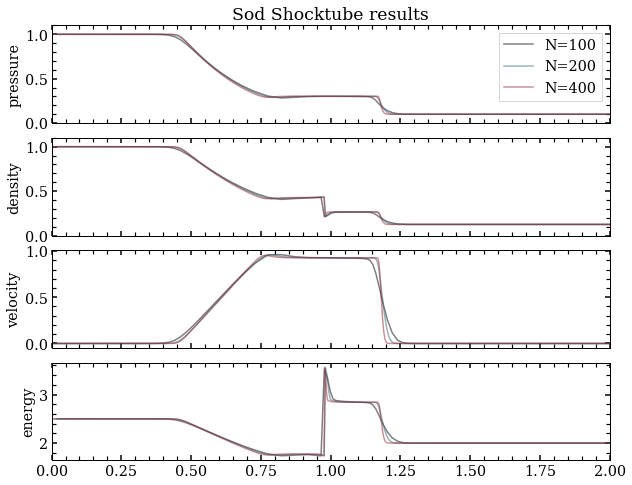

In [80]:
f1 = initialize(Fluid(N= 100))
f2 = initialize(Fluid(N= 200))
f4 = initialize(Fluid(N= 400))

time = 0
while time < 0.245:
    f1, time = update(f1, time)

time = 0
while time < 0.245:
    f2, time = update(f2, time)

time = 0
while time < 0.245:
    f4, time = update(f4, time)


f, axs = plt.subplots(4, sharex=True,figsize=(10,8))

# Since pressure and density are measured at cell center and x at cell edges, need to truncate x arr
axs[0].plot(f1.x[1:], f1.p, linewidth=1.5, color='k', label='N=100', alpha=0.5)
axs[0].plot(f2.x[1:], f2.p, linewidth=1.5, color="#34657C", label='N=200', alpha=0.5)
axs[0].plot(f4.x[1:], f4.p, linewidth=1.5, color='#98282E', label='N=400', alpha=0.5)
axs[0].set_ylabel('pressure')
axs[0].set_ylim(0, 1.1)

axs[0].legend()

axs[1].plot(f1.x[1:], f1.rho, linewidth=1.5, color='k', label='N=100', alpha=0.5)
axs[1].plot(f2.x[1:], f2.rho, linewidth=1.5, color="#34657C", label='N=200', alpha=0.5)
axs[1].plot(f4.x[1:], f4.rho, linewidth=1.5, color='#98282E', label='N=400', alpha=0.5)
axs[1].set_ylabel('density')
axs[1].set_ylim(0, 1.1)

axs[2].plot(f1.x, f1.v, linewidth=1.5, color='k', label='N=100', alpha=0.5)
axs[2].plot(f2.x, f2.v, linewidth=1.5, color="#34657C", label='N=200', alpha=0.5)
axs[2].plot(f4.x, f4.v, linewidth=1.5, color='#98282E', label='N=400', alpha=0.5)
axs[2].set_ylabel('velocity')

axs[3].plot(f1.x[1:], f1.e, linewidth=1.5, color='k', label='N=100', alpha=0.5)
axs[3].plot(f2.x[1:], f2.e, linewidth=1.5, color="#34657C", label='N=200', alpha=0.5)
axs[3].plot(f4.x[1:], f4.e, linewidth=1.5, color='#98282E', label='N=400', alpha=0.5)
axs[3].set_ylabel('energy')

axs[0].set_xlim(0, 2)
axs[1].set_xlim(0, 2)
axs[2].set_xlim(0, 2)
axs[3].set_xlim(0, 2)

plt.subplots_adjust(hspace=0.15)
axs[0].set_title('Sod Shocktube results')
plt.show()


(b) Simple numerical schemes are prone to certain artifacts near the shock interface. What
deviations from the analytic solution do you notice? What numerical improvements would
you apply to address them?

The behavior of the numerical solutions at the shock interface struggle to produce the analytic solution. The points are not able to model the discontinuities perfectly and instead are slightly continuous. To improve the numerical solution, we could model a higher order scheme or increase the physical binning (N).

(c) Check the shock solution for N = 100,200 and 400 grid cells. How quickly is the solution
converging? Is this consistent with your expectations?

The solution converges to the analytic solution quicker with higher N, as expected. It is able to model the discontinuity with a steeper line, however is still not perfectly able to capture the nature of the discontinuity.

(d) Decrease the CFL number to 0.25 and increase it to 1.1. What happens to the shock
solution in each case?

(e) Evaluate how sensitive the solution is to magnitude of the coefficient of artificial viscosity.
Increase the viscosity coefficients by a factor of 2 and decrease them by a factor of 2. How
does the solution change? What impact do the two different viscous components have on
the solution?